<a href="https://colab.research.google.com/github/GustavoGran/ecommerce_recomender/blob/main/ptc3467_caracterizacao_dados_ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importação de bibliotecas**

In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns

## **Importação dos datasets**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/datasets/olist_ecommerce"

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/datasets/olist_ecommerce


In [3]:
customers_file_name = 'olist_customers_dataset.csv'
orders_file_name = 'olist_orders_dataset.csv'
geolocation_file_name = 'olist_geolocation_dataset.csv'
products_file_name = 'olist_products_dataset.csv'
order_items_file_name = 'olist_order_items_dataset.csv'
sellers_file_name = 'olist_sellers_dataset.csv'
order_payments_file_name = 'olist_order_payments_dataset.csv'
product_translation_file_name = 'product_category_name_translation.csv'
order_reviews_file_name = 'olist_order_reviews_dataset.csv'

In [4]:
df_customers = pd.read_csv(customers_file_name,sep=',')
df_orders = pd.read_csv(orders_file_name,sep=',')
df_geolocation = pd.read_csv(geolocation_file_name,sep=',')
df_products = pd.read_csv(products_file_name,sep=',')
df_order_items = pd.read_csv(order_items_file_name,sep=',')
df_sellers = pd.read_csv(sellers_file_name,sep=',')
df_order_payments = pd.read_csv(order_payments_file_name,sep=',')
df_order_reviews = pd.read_csv(order_reviews_file_name,sep=',')

# **Entendendo a origem dos clientes do e-commerce**

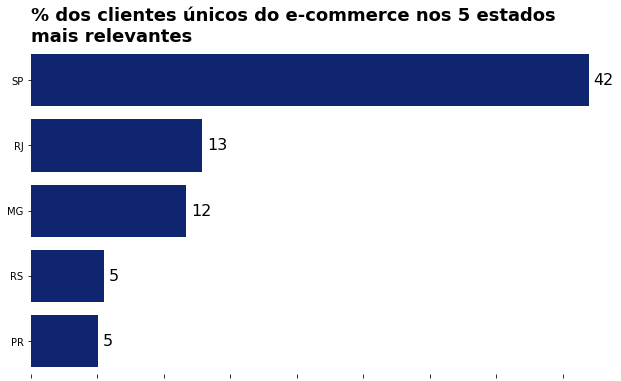

In [5]:
customer_states = df_customers.groupby('customer_state')
unique_customers_by_state = customer_states.customer_unique_id.nunique().sort_values(ascending=False).to_frame()

unique_customers_by_state['customer_state'] = unique_customers_by_state.index
unique_customers_by_state['perc_total_customers'] = unique_customers_by_state.customer_unique_id *(100 / df_customers.customer_unique_id.nunique())

f, ax = plt.subplots(figsize=(10,6))
sns.set_color_codes("dark")

splot = sns.barplot(x="perc_total_customers", y="customer_state", data=unique_customers_by_state.head(5), color="b")

# Add annotations of values
for p in ax.patches:
    ax.annotate("%.f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center", size = 16)

# Add a legend and informative axis label

ax.set(xlim=(0, max(unique_customers_by_state['perc_total_customers'])), 
       xlabel='', ylabel='', xticklabels=[])

ax.set_title("% dos clientes únicos do e-commerce nos 5 estados \nmais relevantes",
             size=18,fontweight="bold",loc = 'left')
ax.grid(False)
sns.despine(offset=10, trim=True, left=True, bottom=True);
plt.show()

# **Integração dos dados**
* **df_customer_orders:** agrupará informações de clientes, dados gerais das compras e avaliações dos clientes
* **df_order_products:** agrupará informações de produtos por compra e informações gerais do produto

In [6]:
# Selects only the most recent review for each order
df_latest_order_reviews = df_order_reviews.groupby('order_id', as_index=False).agg({'review_answer_timestamp' : 'first'})
df_order_reviews = pd.merge(left=df_order_reviews[['order_id','review_answer_timestamp','review_score']], 
                            right= df_latest_order_reviews, on=['order_id','review_answer_timestamp'], how='inner')

customer_cols = ['customer_id','customer_unique_id', 'customer_state']
order_cols = ['customer_id','order_id','order_purchase_timestamp']
review_cols = ['order_id','review_score']

df_customer_orders = pd.merge(
    pd.merge(df_customers[customer_cols], df_orders[order_cols], how='inner', on="customer_id", validate="one_to_one"),
    df_order_reviews[review_cols],
    how='inner', on="order_id",validate="one_to_one")

df_order_products = pd.merge(df_order_items,df_products,how='inner',on='product_id')

In [7]:
# Add number of order items and sum of items price per order

df_grouped_orders = df_order_products.groupby('order_id', as_index=False).agg(
    {'product_id' : ['count','nunique'], 'price' : 'sum'})
df_grouped_orders.columns = ['order_id', 'number_of_items','number_of_unique_items','sum_of_item_prices']

df_customer_orders = pd.merge(df_customer_orders,df_grouped_orders, how='inner', on='order_id', validate="one_to_one")
df_customer_orders.head()

,customer_id,customer_unique_id,customer_state,order_id,order_purchase_timestamp,review_score,number_of_items,number_of_unique_items,sum_of_item_prices
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,4,1,1,124.99
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,SP,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,5,1,1,289.00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,5,1,1,139.94
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,SP,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,5,1,1,149.94
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,5,1,1,230.00


In [8]:
df_customer_orders.order_purchase_timestamp = pd.to_datetime(df_customer_orders.order_purchase_timestamp)

df_first_orders = df_customer_orders.groupby('customer_unique_id', as_index = False).agg(
                        {'order_purchase_timestamp':'min'})
df_first_orders.columns = ['customer_unique_id','first_purchase_timestamp']

df_customer_orders = pd.merge(df_customer_orders,df_first_orders,how='inner',on='customer_unique_id')

In [9]:
df_customer_orders['days_since_first_purchase'] = ((df_customer_orders['order_purchase_timestamp'].dt.date
                                                   - df_customer_orders['first_purchase_timestamp'].dt.date)/np.timedelta64(1,'D')).astype(int)

In [10]:
# Orders dataset in order to find last order previous than current order
df_customer_orders = df_customer_orders.sort_values(by=['customer_unique_id','order_purchase_timestamp'])
df_customer_orders.reset_index(drop=True, inplace=True)

In [11]:
# Searches dataset for last purchase date per customer
df_customer_orders.loc[df_customer_orders['days_since_first_purchase'] == 0,'last_purchase_timestamp'] = pd.to_datetime(np.nan)

for idx in df_customer_orders[df_customer_orders['days_since_first_purchase'] > 0].index:
    df_customer_orders.loc[idx, 'last_purchase_timestamp'] = df_customer_orders.loc[idx-1,'order_purchase_timestamp']

In [12]:
# Calculates number of days since last purchase per customer
df_customer_orders.loc[df_customer_orders['days_since_first_purchase'] == 0,'days_since_last_purchase'] = 0
df_customer_orders.loc[df_customer_orders['days_since_first_purchase'] > 0,'days_since_last_purchase'] = ((df_customer_orders.loc[df_customer_orders['days_since_first_purchase'] > 0,'order_purchase_timestamp'].dt.date
                                                   - df_customer_orders.loc[df_customer_orders['days_since_first_purchase'] > 0,'last_purchase_timestamp'].dt.date)/np.timedelta64(1,'D')).astype(int)

In [13]:
df_customer_orders[df_customer_orders['days_since_first_purchase'] > 0]

,customer_id,customer_unique_id,customer_state,order_id,order_purchase_timestamp,review_score,number_of_items,number_of_unique_items,sum_of_item_prices,first_purchase_timestamp,days_since_first_purchase,last_purchase_timestamp,days_since_last_purchase
107,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,RJ,08204559bebd39e09ee52dcb56d8faa2,2018-01-14 07:36:54,5,1,1,87.90,2017-07-27 14:13:03,171,2017-07-27 14:13:03,171.0
125,d95f60d70d9ea9a7fe37c53c931940bb,004b45ec5c64187465168251cd1c9c2f,AL,9392c5e72885ad5aba87e6223ca9838d,2018-05-26 19:42:48,5,1,1,27.00,2017-09-01 12:11:23,267,2017-09-01 12:11:23,267.0
146,8ac44e9c15d396b8c3c7cbab0fff4536,0058f300f57d7b93c477a131a59b36c3,BA,81a93b2fa39e104b865b2bc471c16008,2018-03-22 18:09:41,5,1,1,72.58,2018-02-19 17:11:34,31,2018-02-19 17:11:34,31.0
250,cbb68c721ba9ddb30d8a490cc1897fa1,00a39521eb40f7012db50455bf083460,DF,cea3e6c11eb60acb9d8d4d51694832f8,2018-06-03 10:12:57,4,1,1,11.55,2018-05-23 20:14:21,11,2018-05-23 20:14:21,11.0
416,71c7265705afd84d030d6adc3122d8dd,011575986092c30523ecb71ff10cb473,MG,ed0a6265b5b0a292cd537214f401f1fc,2018-04-18 21:58:08,4,1,1,63.90,2018-02-17 15:54:49,60,2018-02-17 15:54:49,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98276,a1902b753d5eeb9831f1d3f89a13fba8,ff03923ad1eb9e32304deb7f9b2a45c9,SP,df52ca7830380e7d8f7292e99434eea7,2018-05-26 11:51:22,3,1,1,110.32,2018-04-23 21:49:49,33,2018-04-23 21:49:49,33.0
98324,4b7decb9b58e2569548b8b4c8e20e8d7,ff22e30958c13ffe219db7d711e8f564,SP,54282e97f61c23b78330c15b154c867d,2018-09-03 09:06:57,1,1,1,145.00,2018-08-24 17:02:19,10,2018-08-24 17:02:19,10.0
98484,e53e1eedc9ebf9fa7a3318c60ece1d25,ff8892f7c26aa0446da53d01b18df463,BA,1c308eca3f339414a92e518e2a2e5ee9,2017-11-26 23:25:43,2,1,1,49.95,2017-05-24 16:09:14,186,2017-05-24 16:09:14,186.0
98503,d064be88116eb8b958727aec4cf56a59,ff922bdd6bafcdf99cb90d7f39cea5b3,SP,5f79e2da24a52e76bc22897df03a7901,2017-08-23 13:15:29,3,1,1,40.00,2017-02-22 12:26:42,182,2017-02-22 12:26:42,182.0


# **Descrição de dados**

In [14]:
# Describing
df_desc = df_customer_orders.describe().transpose()
df_desc['interval'] = df_desc['max'] - df_desc['min']
df_desc['IQR'] = df_desc['75%'] -  df_desc['25%']
df_desc['Lim_inf_outlier'] = df_desc['25%'] - 1.5 * df_desc['IQR']
df_desc['Lim_sup_outlier'] = df_desc['75%'] + 1.5 * df_desc['IQR']
df_desc.transpose()

,review_score,number_of_items,number_of_unique_items,sum_of_item_prices,days_since_first_purchase,days_since_last_purchase
count,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000
mean,4.089798,1.141731,1.038098,137.754076,2.894513,2.595109
std,1.343624,0.538452,0.226456,210.645145,26.095843,24.061107
min,1.000000,1.000000,1.000000,0.850000,0.000000,0.000000
25%,4.000000,1.000000,1.000000,45.900000,0.000000,0.000000
50%,5.000000,1.000000,1.000000,86.900000,0.000000,0.000000
75%,5.000000,1.000000,1.000000,149.900000,0.000000,0.000000
max,5.000000,21.000000,8.000000,13440.000000,633.000000,609.000000
interval,4.000000,20.000000,7.000000,13439.150000,633.000000,609.000000
IQR,1.000000,0.000000,0.000000,104.000000,0.000000,0.000000


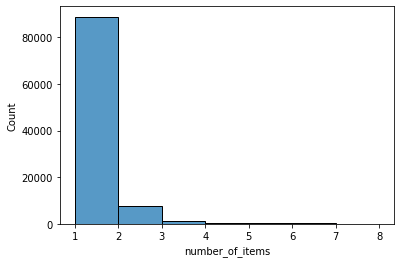

In [15]:
sns.histplot(data=df_customer_orders, x='number_of_items', stat='count',binwidth=1,binrange=(1,8))

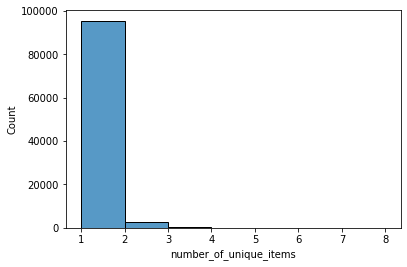

In [16]:
sns.histplot(data=df_customer_orders, x='number_of_unique_items', stat='count',binwidth=1,binrange=(1,8))

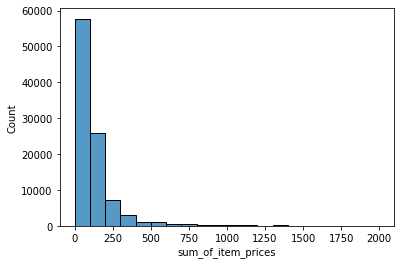

In [17]:
sns.histplot(data=df_customer_orders, x='sum_of_item_prices',binwidth=100.0,binrange=(0.0,2000.0))

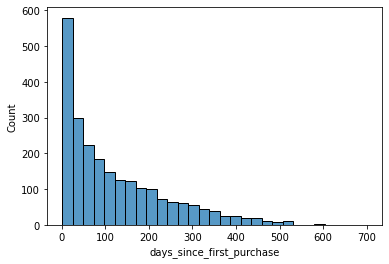

In [18]:
# Sem clientes que só fizeram uma compra
sns.histplot(data=df_customer_orders, x='days_since_first_purchase',binrange=(1,700))

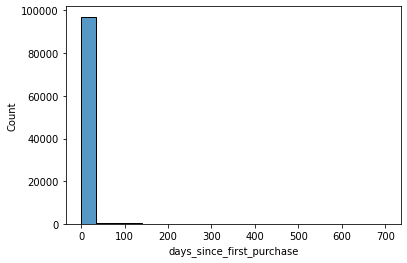

In [19]:
# Com clientes que só fizeram uma compra
sns.histplot(data=df_customer_orders, x='days_since_first_purchase',binrange=(0,700))

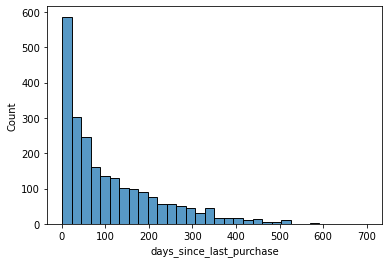

In [20]:
# Sem clientes que só fizeram uma compra
sns.histplot(data=df_customer_orders, x='days_since_last_purchase',binrange=(1,700))

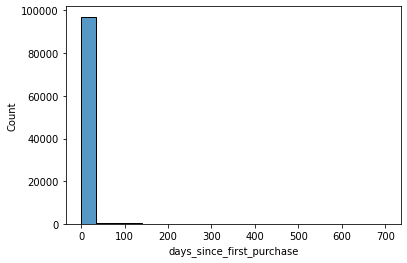

In [21]:
# Com clientes que só fizeram uma compra
sns.histplot(data=df_customer_orders, x='days_since_first_purchase',binrange=(0,700))

# **Visualização de Correlações**

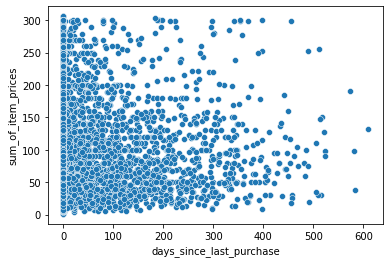

In [48]:
sns.scatterplot(data=df_customer_orders[df_customer_orders['sum_of_item_prices']<=305.90], x='days_since_last_purchase', y='sum_of_item_prices')

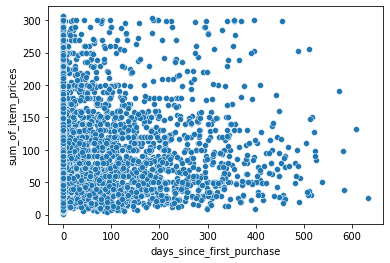

In [49]:
sns.scatterplot(data=df_customer_orders[df_customer_orders['sum_of_item_prices']<=305.900], x='days_since_first_purchase', y='sum_of_item_prices')

In [50]:
df_agg_customers = df_customer_orders[df_customer_orders['sum_of_item_prices']<= 305.9].groupby('customer_unique_id', as_index = False).agg(
                        {'order_id' : 'count',
                         'sum_of_item_prices' : 'mean',
                         'days_since_first_purchase' : 'mean',
                         'days_since_last_purchase' : 'mean',
                         'number_of_unique_items' : 'mean',
                         'number_of_items' : 'mean'})
df_agg_customers.columns = ['customer_unique_id','number_of_purchases','sum_price_items','days_since_first_purchase',
                            'days_since_last_purchase','number_of_unique_items','number_of_items']

In [51]:
df_agg_customers

,customer_unique_id,number_of_purchases,sum_price_items,days_since_first_purchase,days_since_last_purchase,number_of_unique_items,number_of_items
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,0.0,0.0,1.0,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,0.0,0.0,1.0,1.0
2,0000f46a3911fa3c0805444483337064,1,69.00,0.0,0.0,1.0,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,0.0,0.0,1.0,1.0
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...
87831,fffbf87b7a1a6fa8b03f081c5f51a201,1,149.00,0.0,0.0,1.0,1.0
87832,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,0.0,0.0,1.0,1.0
87833,ffff371b4d645b6ecea244b27531430a,1,89.90,0.0,0.0,1.0,1.0
87834,ffff5962728ec6157033ef9805bacc48,1,115.00,0.0,0.0,1.0,1.0


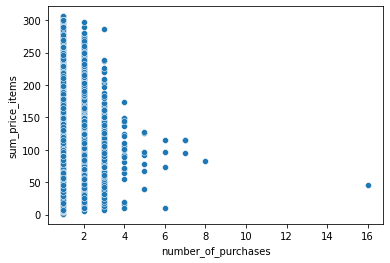

In [52]:
sns.scatterplot(data=df_agg_customers, x='number_of_purchases',y='sum_price_items')

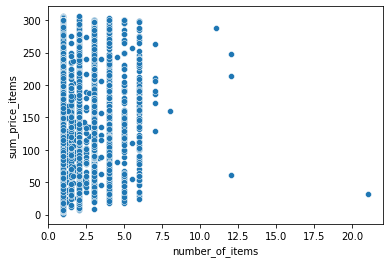

In [53]:
sns.scatterplot(data=df_agg_customers, x='number_of_items',y='sum_price_items')

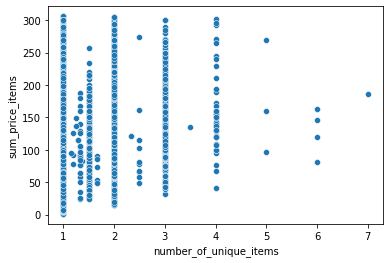

In [54]:
sns.scatterplot(data=df_agg_customers, x='number_of_unique_items',y='sum_price_items')

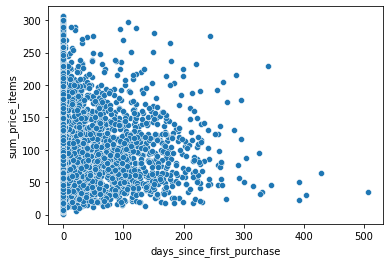

In [55]:
sns.scatterplot(data=df_agg_customers, x='days_since_first_purchase',y='sum_price_items')

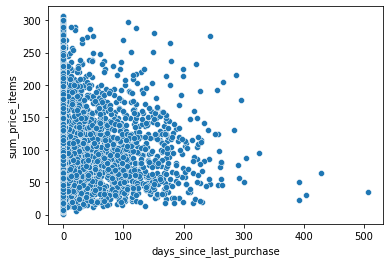

In [56]:
sns.scatterplot(data=df_agg_customers, x='days_since_last_purchase',y='sum_price_items')

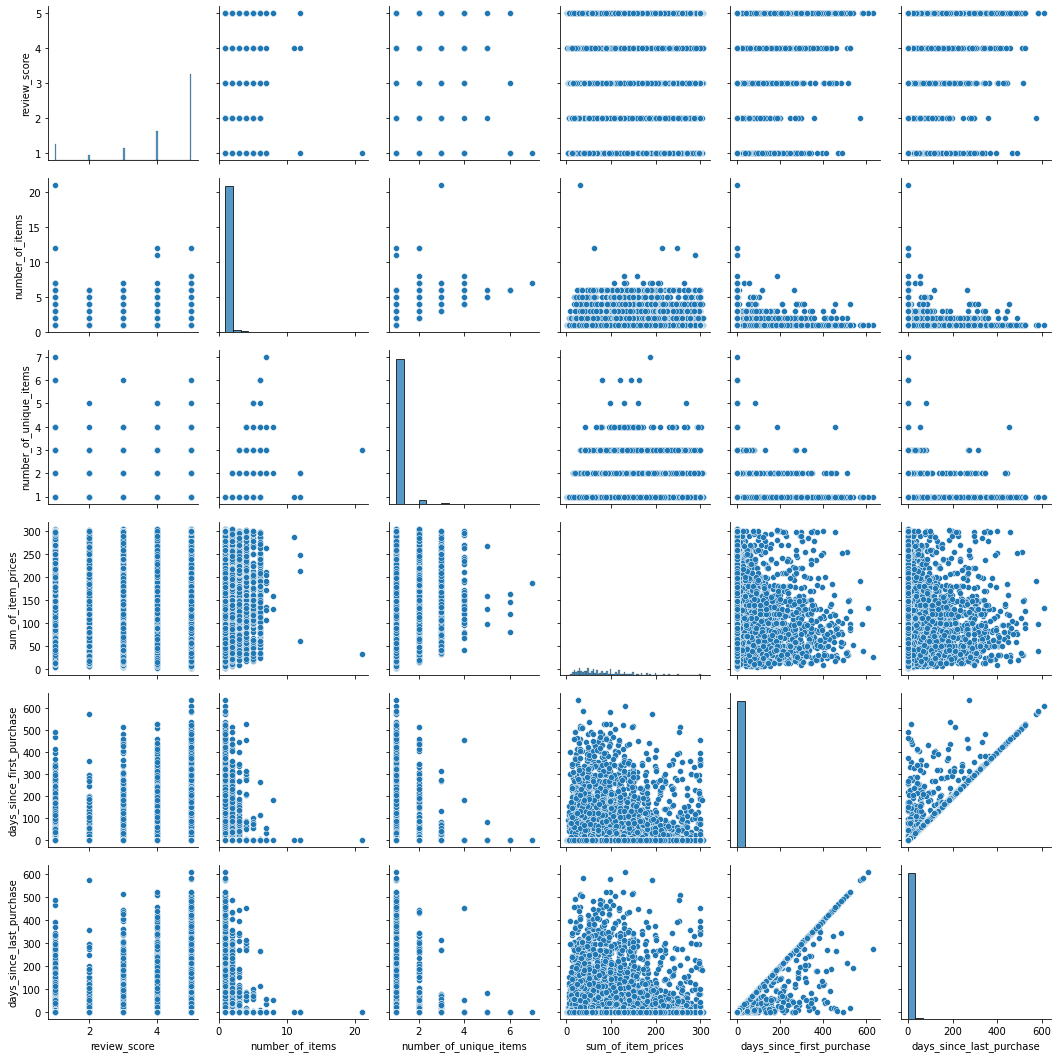

In [58]:
g = sns.PairGrid(df_customer_orders[df_customer_orders['sum_of_item_prices']< 305.9])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)